In [28]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [29]:
# Paths for the original dataset and output folders
BASE_DIR = "images"
TRAIN_DIR = "train"
TEST_DIR = "test"

# Percentage of data to reserve for testing
TEST_SPLIT = 0.2

In [30]:
def create_dir(path):
    """Creates a directory if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path)


def split_dataset():
    """Splits the dataset into train and test sets."""
    # Create train and test directories
    create_dir(TRAIN_DIR)
    create_dir(TEST_DIR)

    # Iterate through each breed folder in the images directory
    for breed_folder in os.listdir(BASE_DIR):
        breed_path = os.path.join(BASE_DIR, breed_folder)

        # Skip if not a directory
        if not os.path.isdir(breed_path):
            continue

        # Get all images in the current breed folder
        images = [os.path.join(breed_path, img) for img in os.listdir(breed_path) if img.endswith(('.jpg', '.png'))]

        # Skip folders with fewer than 2 images
        if len(images) < 2:
            print(f"Skipping {breed_folder} (not enough images)")
            continue

        # Split images into train and test sets
        train_images, test_images = train_test_split(images, test_size=TEST_SPLIT, random_state=42)

        # Create corresponding breed folders in train/test directories
        train_breed_dir = os.path.join(TRAIN_DIR, breed_folder)
        test_breed_dir = os.path.join(TEST_DIR, breed_folder)
        create_dir(train_breed_dir)
        create_dir(test_breed_dir)

        # Copy images to the respective directories
        for img in train_images:
            shutil.copy(img, train_breed_dir)
        for img in test_images:
            shutil.copy(img, test_breed_dir)

        print(f"Processed {breed_folder}: {len(train_images)} train, {len(test_images)} test")

In [31]:
    split_dataset()
    print("Dataset splitting complete!")

Processed n02085620-Chihuahua: 121 train, 31 test
Processed n02085782-Japanese_spaniel: 148 train, 37 test
Processed n02085936-Maltese_dog: 201 train, 51 test
Processed n02086079-Pekinese: 119 train, 30 test
Processed n02086240-Shih-Tzu: 171 train, 43 test
Processed n02086646-Blenheim_spaniel: 150 train, 38 test
Processed n02086910-papillon: 156 train, 40 test
Processed n02087046-toy_terrier: 137 train, 35 test
Processed n02087394-Rhodesian_ridgeback: 137 train, 35 test
Processed n02088094-Afghan_hound: 191 train, 48 test
Processed n02088238-basset: 140 train, 35 test
Processed n02088364-beagle: 156 train, 39 test
Processed n02088466-bloodhound: 149 train, 38 test
Processed n02088632-bluetick: 136 train, 35 test
Processed n02089078-black-and-tan_coonhound: 127 train, 32 test
Processed n02089867-Walker_hound: 122 train, 31 test
Processed n02089973-English_foxhound: 125 train, 32 test
Processed n02090379-redbone: 118 train, 30 test
Processed n02090622-borzoi: 120 train, 31 test
Processed

KeyboardInterrupt: 

In [32]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflowjs as tfjs  # Import TensorFlow.js converter
import matplotlib.pyplot as plt
import json

In [35]:
# Paths to the train and test datasets
TRAIN_DIR = "train"
TEST_DIR = "test"

# Hyperparameters
IMAGE_SIZE = (224, 224)  # Image dimensions for resizing
BATCH_SIZE = 32
EPOCHS = 20
INITIAL_EPOCHS = 10  # Epochs before fine-tuning
FINE_TUNE_EPOCHS = 10  # Additional epochs for fine-tuning

def load_datasets():
    """Load the training and testing datasets with data augmentation."""
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
    )

    # Save class names to breeds.json
    class_names = train_ds.class_names
    with open("public/breeds.json", "w") as f:
        json.dump(class_names, f)
    print(f"Class names saved to breeds.json: {class_names}")

    train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, test_ds, class_names

print(f"Current working directory: {os.getcwd()}")


Current working directory: C:\Users\Admin\PycharmProjects\ML_DogBreedClassification


In [34]:
def create_model(num_classes):
    """Define the model with transfer learning."""
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        include_top=False,  # Exclude the final classification layer
        weights='imagenet'  # Use pretrained weights
    )
    base_model.trainable = False  # Freeze the base model layers

    # Add classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model


def fine_tune_model(model, base_model):
    """Unfreeze some layers of the base model for fine-tuning."""
    base_model.trainable = True
    # Fine-tune from the last 30 layers of the base model
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Recompile with a lower learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [25]:
def plot_metrics(history):
    """Plot training metrics: Loss and Accuracy."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [26]:
train_ds, test_ds, class_names = load_datasets()
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")


Found 16418 files belonging to 120 classes.
Found 4162 files belonging to 120 classes.
Class names saved to breeds.json: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_b

In [18]:
# Create and compile the model
model = create_model(num_classes)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])  # Ensure 'accuracy' is explicitly included

# Initial training phase
print("Starting initial training...")
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=INITIAL_EPOCHS
)

# Fine-tuning phase
print("Fine-tuning the model...")
fine_tune_model(model, model.layers[0])  # Pass the base model
fine_tune_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=FINE_TUNE_EPOCHS,
    initial_epoch=INITIAL_EPOCHS
)

# Combine training histories for unified plotting
# Replace 'accuracy' with the actual key if it's different
accuracy_key = 'accuracy'  # or 'sparse_categorical_accuracy' if needed
val_accuracy_key = 'val_accuracy'  # or 'val_sparse_categorical_accuracy'

history.history[accuracy_key].extend(fine_tune_history.history[accuracy_key])
history.history[val_accuracy_key].extend(fine_tune_history.history[val_accuracy_key])
history.history['loss'].extend(fine_tune_history.history['loss'])
history.history['val_loss'].extend(fine_tune_history.history['val_loss'])


Starting initial training...
Epoch 1/10
514/514 [==============================] - 207s 400ms/step - loss: 4.7966 - accuracy: 0.0111 - val_loss: 4.7835 - val_accuracy: 0.0125
Epoch 2/10
514/514 [==============================] - 196s 380ms/step - loss: 4.7776 - accuracy: 0.0123 - val_loss: 4.7666 - val_accuracy: 0.0132
Epoch 3/10
514/514 [==============================] - 202s 393ms/step - loss: 4.7687 - accuracy: 0.0116 - val_loss: 4.7689 - val_accuracy: 0.0144
Epoch 4/10
514/514 [==============================] - 209s 406ms/step - loss: 4.7625 - accuracy: 0.0119 - val_loss: 4.7541 - val_accuracy: 0.0156
Epoch 5/10
514/514 [==============================] - 201s 392ms/step - loss: 4.7566 - accuracy: 0.0140 - val_loss: 4.7641 - val_accuracy: 0.0144
Epoch 6/10
514/514 [==============================] - 201s 392ms/step - loss: 4.7558 - accuracy: 0.0138 - val_loss: 4.7448 - val_accuracy: 0.0163
Epoch 7/10
514/514 [==============================] - 201s 391ms/step - loss: 4.7537 - accuracy

KeyError: 'accuracy'

Model saved as dog_breed_classifier.h5
Model saved in TensorFlow.js format at: tfjs_model


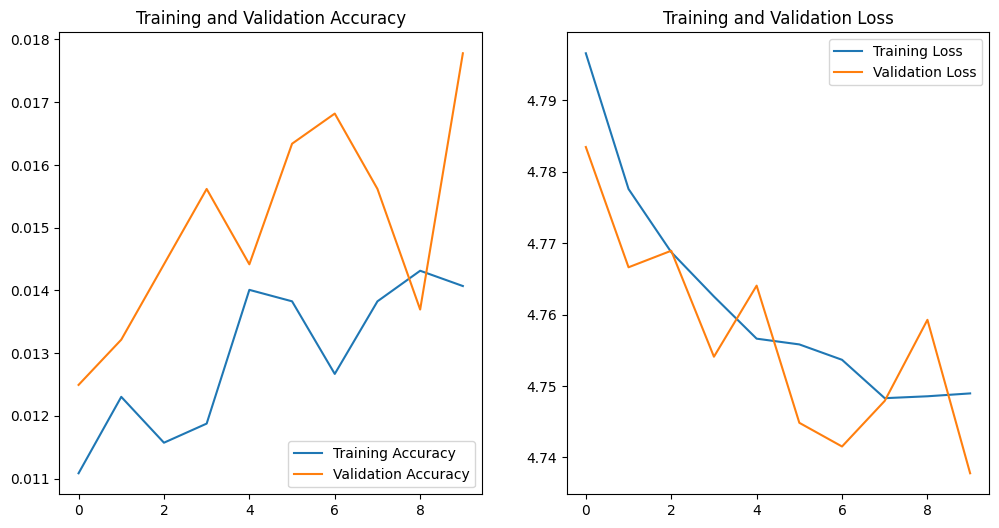

In [19]:
# Save the trained model
model.save("dog_breed_classifier.h5")
print("Model saved as dog_breed_classifier.h5")

# Save in TensorFlow.js format
tfjs_output_dir = "public/tfjs_model"
tfjs.converters.save_keras_model(model, tfjs_output_dir)
print(f"Model saved in TensorFlow.js format at: {tfjs_output_dir}")

# Plot metrics
plot_metrics(history)